In [1]:
# Libraries and Functions

import os
import openai
import pandas as pd
import re
import time
import numpy as np
import json
import gc
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from sklearn import svm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import requests
from IPython.display import Image
from IPython.core.display import HTML
from imblearn.combine import SMOTETomek
import miceforest as mf
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from tqdm import tqdm
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Constants
openai.api_key = "YOUR OPEN API KEY" # Replace this with your OPENAI API key
WD = Path.cwd().parent / "data" # Replace this with your working data directory

RANDOM_SEED = 333

# Introduction


In this notebook, we employed a downsampling approach, combining ChatGPT with ML classification techniques, to label all emergency department (ED) visit narratives from 2013 to 2023. We outlined a pipeline for acquiring the complete dataset spanning all incidents and age groups, subsequently deriving six categorical variables: fall-related accident, cause of the accident, body position prior to accident, activity prior incident, home location, and facilities.

Our analysis underscored the temporal trends of falls among the elderly in both absolute and relative terms. We also evaluated how our crafted indicators influence the likelihood of falls versus other events and subsequent hospitalizations post-fall. Notably, our study incorporated a comparative analysis based on age. We emphasized the advantages of using a comprehensive ED dataset and highlighted the significance of our extracted variable categories in analyzing falls in the elderly.


In this submission, we used verified unintentional falls from primary_data.csv and all ED records in the NEISS database from 2013 to 2022 (available at https://www.cpsc.gov/cgibin/NEISSQuery/). During the labeling phase we obtained samples of coded records using the ChatGPT API and also manually tagged records to compare the agreement between automated approach and human-coders. Those samples can be found here: https://drive.google.com/drive/folders/1-dr8ukDn2jIURFwd-CvlZlDwrr0JBRlz

The schematic representation of the full pipeline can be seen below.

![](images/pipeline.png)

# 1. Preprocessing

Loading full NEISS database from 2013 to 2022.

In [2]:
### Load files
list_files = list((WD / 'fulldb/').glob("*"))
list_dfs = []
for file in list_files:
    print(file)
    list_dfs.append(pd.read_excel(file))
    gc.collect()
df_full = pd.concat(list_dfs)

# Lowercase columns
df_full.columns = [x.lower() for x in df_full.columns]

# Select only adults 18+
df_full = df_full[(df_full['age'] < 199) & (df_full['age'] >= 18)]

By using regular expressions, we removed age, sex and most of the diagnosis descriptions from the narrative field since this information was already contained in other non-textual columns. We also expanded the most popular abbreviations using manually constructed dictionaries.

In [3]:
def removeAgeSex(x):
    
    pattern = r"(\d{1,3})(\s{0,4}|\-|')(mother|mom|month old|month|mo old|m/o|mo|m o|m|day old|year old|year|yr old|nyo|yo|y/o|y.o.|y o|yr|y)\s{0,4}(woman|female|man|male|wf|wm|bm|bf|mf|mm|m|f|w|\s{0,3})"
    s = re.sub(pattern, "", x)

    s = s.strip()
    
    return s

def removeDiagnosis(x):
    
    s = re.sub(r'^[^a-zA-Z0-9]+', '', x)

    if ( len(re.split(r'\bs/p\b', s))==2 and (not s.endswith('s/p')) ):
        s = re.split(r'\bs/p\b', s)[1]
            
    if 'status post' in s:
        s = s.split('status post')[1]
    
    if ( ('dx' in s) and (not s.startswith('dx')) ):
        if len(s.split('dx')[0]) > 2:
            s = s.split('dx')[0]
    
    if '>>' in s:
        s = s.split('>>')[0]
        
    s = s.strip()
    
    if len(s) <= 3:
        s = x

    return s


def expandAbbreviations(s, dict_abb_exp):
    
    for abb, word in dict_abb_exp.items():
        s = re.sub(r'\b{}\b'.format(abb), word, s)
        
    return s

# To lower
df_full['text'] = df_full['narrative'].str.lower()

# Remove Age and Sex
df_full['text'] = df_full['text'].apply(lambda x: removeAgeSex(x))

# Remove diagnosis
df_full['text'] = df_full['text'].apply(lambda x: removeDiagnosis(x))

# Abbreviation expansion
dict_abb_exp = {
    'pt':'patient',
    'c/o':'complains of',
    'lac':'laceration',
    'rt':'right',
    'l':'left',
    'r':'right',
    's/p':'status post',
    'w/':'with',
    '@':'at',
    'fx':'fracture',
    'loc':'loss of consciousness',
    'ed':'emergency department',
    'sts':'states',
    'acc':'accidentally',
    'w':'with',
    'hx':'history',
    'hd':'head',
    'bib':'brought in by',
    'lt':'left',
    'inj':'injury',
    'er':'emergency room',
    'bal':'blood alcohol level',
    'fb':'foreign body',
    'w/o':'without',
    'pn':'pain',
    'nh':'nursing home',
    'co':'complains of',
    'p/w':'presents with',
    'lwr':'lower',
    'str':'strained',
    'spr':'sprain',
    'sust':'sustained',
    'h/o':'history of',
    "s'd&f":'slipped, tripped, and fell',
    "t'd&f":'tripped and fell',
    'bwd':'backward'
    }
df_full['text'] = df_full['text'].apply(lambda x: expandAbbreviations(x, dict_abb_exp))

# Remove short texts
df_full = df_full[(df_full['text'].str.len() > 3)]

# Remove diagnosis 'loss of consciousness'
df_full['text'] = df_full['text'].str.replace('loss of consciousness', '')

Preprocessing of other non-textual variables.

In [4]:
# Add labels to categories
with Path(WD / "variable_mapping.json").open("r") as f:
    mapping = json.load(f, parse_int=True)
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}
for col in mapping.keys():
    df_full[col] = df_full[col].map(mapping[col])

# Indicate primary_dataset
df_primary = pd.read_csv(WD / 'primary_data.csv')
set_primary = set(df_primary['cpsc_case_number'].values)
df_full['primary'] = df_full['cpsc_case_number'].apply(lambda x: x in set_primary)

# Hospitalized
df_full['hospitd'] = df_full['disposition'].replace(
    {'1 - TREATED/EXAMINED AND RELEASED':0,
     '6 - LEFT WITHOUT BEING SEEN':0,
     '4 - TREATED AND ADMITTED/HOSPITALIZED':1,
     '5 - HELD FOR OBSERVATION':1,
     '2 - TREATED AND TRANSFERRED':1,
     '8 - FATALITY INCL. DOA, DIED IN ER':0,
     '9 - UNKNOWN, NOT STATED':0})

# Sex
df_full['sex'] = df_full['sex'].replace({'UNKNOWN':np.nan, 'NON-BINARY/OTHER':np.nan})

# Date
df_full['treatment_date'] = pd.to_datetime(df_full['treatment_date'])
df_full['year'] = 'y_' + df_full['treatment_date'].dt.year.astype(str)
df_full['month'] = 'm_' + df_full['treatment_date'].dt.month.astype(str)
df_full['treatment_ym'] = pd.to_datetime(df_full['treatment_date'].dt.strftime('%Y-%m'))

# Primary
df_full['primary'] = df_full['primary'].astype(int)

# --- Recode small categories

# Body part
value_counts = pd.Series(np.concatenate([df_full['body_part'].values,
                                         df_full['body_part_2'].values])).value_counts()
to_replace = value_counts[value_counts < 1000].index
df_full['body_part'] = df_full['body_part'].where(df_full['body_part'].isin(to_replace) == False, '00 - OTHER')
df_full['body_part_2'] = df_full['body_part_2'].where(df_full['body_part_2'].isin(to_replace) == False, '00 - OTHER')

# Diagnosis
value_counts = pd.Series(np.concatenate([df_full['diagnosis'].values,
                                         df_full['diagnosis_2'].values])).value_counts()
to_replace = value_counts[value_counts < 100000].index # 100,000
df_full['diagnosis'] = df_full['diagnosis'].where(df_full['diagnosis'].isin(to_replace) == False, '00 - OTHER')
df_full['diagnosis_2'] = df_full['diagnosis_2'].where(df_full['diagnosis_2'].isin(to_replace) == False, '00 - OTHER')

# Product
value_counts = pd.Series(np.concatenate([df_full['product_1'].values,
                                         df_full['product_2'].values,
                                         df_full['product_3'].values])).value_counts()
to_replace = value_counts[value_counts < 10000].index # 10,000 for products
df_full['product_1'] = df_full['product_1'].where(df_full['product_1'].isin(to_replace) == False, '00 - OTHER')
df_full['product_2'] = df_full['product_2'].where(df_full['product_2'].isin(to_replace) == False, '00 - OTHER')
df_full['product_3'] = df_full['product_3'].where(df_full['product_3'].isin(to_replace) == False, '00 - OTHER')

# Location
value_counts = df_full['location'].value_counts()
to_replace = value_counts[value_counts < 1000].index
df_full['location'] = df_full['location'].where(df_full['location'].isin(to_replace) == False, 'OTHER')

# Drug and Alcohol
df_full['drug'] = df_full['drug'].replace({np.nan:'No/Unk'})
df_full['alcohol'] = df_full['alcohol'].replace({np.nan:'No/Unk'})

# To binary
df_full['female'] = df_full['sex'].apply(lambda x: 1 if x=='FEMALE' else 0)
df_full['drug'] = df_full['drug'].replace({'No/Unk':0, 'Yes':1})
df_full['alcohol'] = df_full['alcohol'].replace({'No/Unk':0, 'Yes':1})

# Define the bins and their labels
bins = [0, 64, 74, 84, 120]
labels = ["18-64", "65-74", "75-84", "85+"]
df_full['age_group'] = pd.cut(df_full['age'], bins=bins, labels=labels,
                              right=False, include_lowest=True)

# Reset index
df_full = df_full.reset_index(drop=True)

In [5]:
df_full.to_pickle(WD / 'intermediate_outputs/df_full_pp.obj')

To build ML classification models on top of the samples labeled by GPT-4, we created embeddings of the narrative field using sentence transformers model "all-MiniLM-L12-v2" that provides a vector representation for sentences and short paragraph.

In [6]:
# Load full dataset
df_full = pd.read_pickle(WD / 'intermediate_outputs/df_full_pp.obj')

Path("embeddings").mkdir(exist_ok=True)

# Load sentence transformer
transformer = SentenceTransformer('all-MiniLM-L12-v2')

# Split texts into chunk
list_texts_full = list(df_full['text'].values)
chunk_size = 10000
list_chunks = [list_texts_full[i:i+chunk_size] for i in range(0, len(list_texts_full), chunk_size)]

# Create embeddings by chunk
for i in tqdm(range(len(list_chunks))):
    chunk_text = list_chunks[i]
    embeddings = transformer.encode(chunk_text)
    with open('embeddings/{}.npy'.format(str(i)), 'wb') as f:
        np.save(f, embeddings)
    if (i % 10)==0:
        gc.collect()
    
# Combine embeddings
list_embs = []
for i in range(len(os.listdir('embeddings'))):
    file = 'embeddings/{}.npy'.format(str(i))
    list_embs.append(np.load(file))
    print(i)
df_embs = pd.DataFrame(np.concatenate(list_embs))
df_embs.to_pickle(WD / 'intermediate_outputs/df_embs.obj')

To optimize GPT's use, we categorized our texts into 20 clusters based on their embeddings and then drew 50 samples from each. This approach gave us a more diverse initial sample than random selection would.

We labeled "home location" and "facility type" only for entries with the location set to HOME or PUBLIC. Ultimately, we got three stratified samples: one for the full database, one for HOME location, and one for PUBLIC location, each with 1,000 narratives.

In [7]:
# Datasets
df_full = pd.read_pickle(WD / 'intermediate_outputs/df_full_pp.obj')
df_full = df_full.reset_index(drop=True)
df_home = df_full[df_full['location'] == 'HOME']
df_public = df_full[df_full['location'] == 'PUBLIC']

# Embeddings
df_embs_full = pd.read_pickle(WD / 'intermediate_outputs/df_embs.obj')
df_embs_home = df_embs_full.iloc[df_home.index]
df_embs_public = df_embs_full.iloc[df_public.index]

# Clustering
n_clust = 20
df_full['cluster'] = MiniBatchKMeans(n_clust).fit(df_embs_full).labels_
df_home['cluster'] = MiniBatchKMeans(n_clust).fit(df_embs_home).labels_
df_public['cluster'] = MiniBatchKMeans(n_clust).fit(df_embs_public).labels_

# Stratified sampling
n_sample = 1000
df_sample_full = df_full.groupby('cluster', group_keys=False).apply(
    lambda x: x.sample(int(n_sample/n_clust), random_state=RANDOM_SEED))
df_sample_home = df_home.groupby('cluster', group_keys=False).apply(
    lambda x: x.sample(int(n_sample/n_clust), random_state=RANDOM_SEED))
df_sample_public = df_public.groupby('cluster', group_keys=False).apply(
    lambda x: x.sample(int(n_sample/n_clust), random_state=RANDOM_SEED))

# 2. Labeling


Drawing on previous literature (Moreland et al. 2021, Kakara et al. 2021, Omaki et al. 2023), we established a set of variables reflecting potential contributors to unintentional falls and other accidents. 

The following classification of variables and categories was used in our work:

**1. Fall** - indicates if the accident described in the narrative is related to the unintentional fall of the patient.
* 'fall' (the accident is about the unintentional fall of the patient)
* 'not fall' (all other accidents)

**2. Activity** - activity of the patient before the accident.
* 'stationary' (sitting still, standing still, etc.),
* 'locomotion' (walking, climbing, etc.),
* 'body positioning' (leaning, reaching, bending, etc.),
* 'manual handling' (carrying, pushing, moving, etc.),
* 'sports activity' (playing football, training, etc.),
* 'other activity' (activities that do not occur among other categories),
* 'activity is not defined' (the text does not include a description of the prior activity)

**3. Body position** - the body position of the patient before the accident.
* 'standing' (standing still, walking, etc.),
* 'sitting' (sitting on a chair, sofa, etc.), 
* 'lying' (lying in bed, etc.),
* 'other body position' (body positions that do not occur among other categories), 
* 'position is not defined' (the text does not include a description of the prior body position)

**4. Cause** - the main cause of the accident.
* 'medical' (syncope, stroke, heart attack etc.),
* 'not medical' (all other causes)

**5. Facility** - the facility where the accident happened (only for 'PUBLIC' locations)
* 'assisted living' (nursing home, etc.),
* 'healthcare facilities' (hospital, doctor's office, etc.),
* 'retail spaces' (store, mall, etc.),
* 'transportation hubs' (subway, airport, etc.),
* 'food & hospitality' (restaurant, hotel, etc.),
* 'entertainment & leisure' (bar, theatre, etc.),
* 'penitentiary' (jail, prison, etc.),
* 'religious facilities' (church, synagogue, etc.),
* 'housing' (home, residence, etc.),
* 'other type of facility' (facilities that do not occur among other categories),
* 'outdoor location' ('park, 'street, etc.),
* 'location is not defined' (the text does not include the location of the accident)

**6. Home location** - specific location inside the home where the accident happened (only for 'HOME' locations)
* 'bathroom',
* 'bedroom',
* 'living room',
* 'doorways',
* 'stairs',
* 'kitchen',
* 'other home location' (home locations that do not occur among other categories),
* 'home in general' (accident happened at home, but exact location is not mentioned)
* 'outdoor location' (park, street, etc.),
* 'location is not defined' (the text does not include the location of the accident)

Compared to fully unsupervised methods like Topic Modelling, our approach offered greater control over categorization, tailored to the specific research question at hand. It allowed us to extract both concrete (e.g., locations) and more latent variables (e.g., pre-accident activity) simultaneously. Additionally, it addressed missings in the text by including the option "variable is not defined."

We formulated a separate few-shot prompt for ChatGPT for each variable, detailed below. Although we experimented with various prompt creation methods like Chain-of-Thoughts and In-Context Impersonation, adding few-shot examples to the prompt led to the most consistent improvement in quality.

In [8]:
# ========= 0. FALL-NOT FALL
prompt_fall = '''    
1. Detect the texts related to patients' falls.
2. Classify the text into one of the following categories:
    'fall' (the accident is about the unintentional fall of the patient)
    'not fall' (all other accidents)
3. Output the category. 
Do not provide any additional information except a selected category.

Examples:
text: slipped on wet floor. hit side and head.
response: fall

text: computer tower fell on left foot
response: not fall

text: jammed finger while playing football
response: not fall

text: fell down steps
response: fall

text: states he was helping move heavy furniture when a bookshelf fell onto right hand smashing right finger
response: not fall

text: fell  off  his  skateboard
response: fall

text: slipped on wet floor. hit side and head.
response: fall

text: computer tower fell on left foot
response: not fall
'''

# ========= 1. ACTIVITY
prompt_activity = '''    
1. Detect the main activity a patient was doing before the accident.
2. Classify the prior activity into one of the following categories:
    'stationary' (sitting still, standing still, etc.),
    'locomotion' (walking, climbing, etc.),
    'body positioning' (leaning, reaching, bending, etc.),
    'manual handling' (carrying, pushing, moving, etc.),
    'sports activity' (playing football, training, etc.),
    'other activity' (activities that do not occur among other categories),
    'activity is not defined' (the text does not include a description of the prior activity)
3. Output the category. 
Do not provide any additional information except a selected category.

Examples:
text: felt dizzy while sitting on side of bed at home, slid off bed
response: stationary

text: while walking tripped and fell onto floor.
response: locomotion

text: was leaning over to get something out of his refrigeraotr and fell to the floor
response: body positioning

text: strained chest when lifting container
response: manual handling

text: fall while playing basketball
response: sports activity

text: fell striking head of floor
response: activity is not defined
'''

# ========= 2. BODY POSITION
prompt_position = '''
1. Detect the body position of the patient right before the accident.
2. Classify the body position into one of the following categories:
    'standing' (standing still, walking, etc.),
    'sitting' (sitting on a chair, sofa, etc.), 
    'lying' (lying in bed, etc.),
    'other body position' (body positions that do not occur among other categories), 
    'position is not defined' (the text does not include a description of the prior body position)
3. Output the category. 
Do not provide any additional information except a selected category.

Examples:
text: slipped on a stair.
response: standing

text: fell off a chair onto floor
response: sitting

text: patient fell out of bed and hit head on hardwood floor.
response: lying

text: bent over to pick up something off the floor and had sudden lower back pain.
response: other body position

text: fell striking head of floor
response: position is not defined
'''

# ========= 3. CAUSE
prompt_cause = '''
1. Detect the main cause of the accident.
2. Classify the cause into one of the following categories:
    'medical' (syncope, stroke, heart attack etc.),
    'not medical' (all other causes)
3. Output the category. 
Do not provide any additional information except a selected category.

Examples:
text: blacked out and fell to the floor landing on her buttocks.
response: medical

text: was mopping floor, lost balance, slipped on wet floor
response: not medical

text: was pushed by daughter and struck head on stove
response: not medical

text: was walking from his bathroom and felt dizzy and had chest pain, then he fell
response: medical

text: fell and hit head
response: not medical
'''

# ========= 4. FACILITY
# ~~~ Only for 'PUBLIC' location

prompt_facility = '''
1. Detect the facility where the accident happened.
2. Classify the facility into one of the following categories:
    'assisted living' (nursing home, etc.),
    'healthcare facilities' (hospital, doctor's office, etc.),
    'retail spaces' (store, mall, etc.),
    'transportation hubs' (subway, airport, etc.),
    'food & hospitality' (restaurant, hotel, etc.),
    'entertainment & leisure' (bar, theatre, etc.),
    'penitentiary' (jail, prison, etc.),
    'religious facilities' (church, synagogue, etc.),
    'housing' (home, residence, etc.),
    'other type of facility' (facilities that do not occur among other categories),
    'outdoor location' ('park, 'street, etc.),
    'location is not defined' (the text does not include the location of the accident)
3. Output the category. 
Do not provide any additional information except a selected category.

Examples:
text: struck head on revolving glass door at hospital
response: healthcare facilities

text: hit head on wall at restaurant closed head injury
response: food & hospitality

text: riding bicycle cut right hand on metal railing
response: outdoor location

text: fell into door frame.
response: location is not defined
'''

# ========= 5. LOCATION INSIDE HOME (+)
# ~~~ Only for 'HOME' location

prompt_homeloc = '''
1. Detect the specific location inside the home where the accident happened.
2. Classify the location into one of the following categories:
   'bathroom',
   'bedroom',
   'living room',
   'doorways',
   'stairs',
   'kitchen',
   'other home location' (home locations that do not occur among other categories),
   'home in general' (accident happened at home, but exact location is not mentioned)
   'outdoor location' (park, street, etc.),
   'location is not defined' (the text does not include the location of the accident)
3. Output the category. 
Do not provide any additional information except a selected category.

Examples:
text: fell from bed an injured rib,weakness,fall,
response: bedroom

text: slipped on stairs and hit his chest
response: stairs

text: tripped over a rug at home and fractured right hip
response: home in general

text: collided with parked car while riding bike 
response: outdoor location

text: hit her foot into a wall.
response: location is not defined
'''

Run GPT-4 API to obtain labeled samples.

In [9]:

def queryGpt(text_sample, prompt, model):
    task = f'''
    You are a text classification model.
    You are given a text desciption of an accident.
    Do the following:
    {prompt}
    '''

    input_text = f'''
    Text: "{text_sample}"
    Your response:
    '''

    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai.api_key}"
    }
    params = {
        "model": model,
        "messages": [{"role": "system", "content": task},
                     {"role": "user", "content": input_text}],
        "temperature": 0,
        'n':1
    }
    retries = 5
    timeout = 20
    
    while retries > 0:
        try:
            response = requests.post(url, headers=headers, data=json.dumps(params), timeout=timeout)
            response.raise_for_status()
            gpt_output = response.json()['choices'][0]['message']['content']
            break
        except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
            retries -= 1
            print(f"Request failed with error: {e}")
            time.sleep(20)
    
    if retries == 0:
        gpt_output = '===FAIL==='
        print('===FAIL===')
    
    return gpt_output


def labelSample(df, prompt, model):
    
    list_labels = []
    for i in range(len(df)):
        
        text = df['text'].iloc[i]              
        
        gpt_label = queryGpt(text_sample = text,
                             prompt = prompt,
                             model = model)
        list_labels.append(gpt_label)
        
        if (i % 10 == 0):
            print(i)
        time.sleep(1)
        
    return list_labels

# --- 0. Fall-Not Fall
print('fall')
df_sample_full['fall'] = labelSample(df = df_sample_full, prompt = prompt_fall, model = "gpt-4")
df_sample_full.to_pickle(WD / 'intermediate_outputs/df_sample_full.obj')  # <= available at additional_datasets folder

# --- 1. Activity
print('activity')
df_sample_full['activity'] = labelSample(df = df_sample_full, prompt = prompt_activity, model = "gpt-4")
df_sample_full.to_pickle(WD / 'intermediate_outputs/df_sample_full.obj')  # <= available at additional_datasets folder

# --- 2. Position
print('position')
df_sample_full['position'] = labelSample(df = df_sample_full, prompt = prompt_position, model = "gpt-4")
df_sample_full.to_pickle(WD / 'intermediate_outputs/df_sample_full.obj')  # <= available at additional_datasets folder

# --- 3. Cause
print('cause')
df_sample_full['cause'] = labelSample(df = df_sample_full, prompt = prompt_cause, model = "gpt-4")
df_sample_full.to_pickle(WD / 'intermediate_outputs/df_sample_full.obj')  # <= available at additional_datasets folder

# --- 4. Home location
print('homeloc')
df_sample_home['homeloc'] = labelSample(df = df_sample_home, prompt = prompt_homeloc, model = "gpt-4")
df_sample_home.to_pickle(WD / 'intermediate_outputs/df_sample_home.obj')  # <= available at additional_datasets folder

# --- 5. Facility
print('facility')
df_sample_public['facility'] = labelSample(df = df_sample_public, prompt = prompt_facility, model = "gpt-4")
df_sample_public.to_pickle(WD / 'intermediate_outputs/df_sample_public.obj')  # <= available at additional_datasets folder

To ensure that ChatGPT's responses matched our desired labels, we postprocessed the output.

In [10]:
# Load the samples
df_sample_full = pd.read_pickle(WD / 'intermediate_outputs/df_sample_full.obj')
df_sample_public = pd.read_pickle(WD / 'intermediate_outputs/df_sample_public.obj')
df_sample_home = pd.read_pickle(WD / 'intermediate_outputs/df_sample_home.obj')

# Clean the sample of responses
def cleanResponse(answer, list_categories, nonmatch_category):
    
    # to lower
    answer = answer.lower()
    
    # keep matches
    answer = next((resp for resp in list_categories if resp in answer), answer)    

    # not matches to other
    if answer not in list_categories:
        answer = nonmatch_category
    
    return answer

# --- 0. Fall-Not Fall
categories_fall = ['not fall', 'fall']
df_sample_full['fall'] = df_sample_full['fall'].apply(
    lambda x: cleanResponse(x, categories_fall, 'not fall'))

# --- 1. Activity
categories_activity = ['stationary', 'locomotion', 'body positioning',
                      'manual handling', 'sports activity', 'other activity',
                      'activity is not defined']
df_sample_full['activity'] = df_sample_full['activity'].apply(
    lambda x: cleanResponse(x, categories_activity, 'other activity'))

# --- 2. Position
categories_position = ['standing', 'sitting', 'lying',
                       'other body position', 'position is not defined']
df_sample_full['position'] = df_sample_full['position'].apply(
    lambda x: cleanResponse(x, categories_position, 'other body position'))

# --- 3. Cause
categories_cause = ['not medical', 'medical']
df_sample_full['cause'] = df_sample_full['cause'].apply(
    lambda x: cleanResponse(x, categories_cause, 'not medical'))

# --- 4. Facility
categories_facility = ['assisted living', 'healthcare facilities', 'retail spaces',
                       'transportation hubs', 'food & hospitality', 'entertainment & leisure',
                       'penitentiary', 'religious facilities', 'housing', 
                       'other type of facility', 'outdoor location', 'location is not defined']
df_sample_public['facility'] = df_sample_public['facility'].apply(
    lambda x: cleanResponse(x, categories_facility, 'other type of facility'))

# --- 5. Home location
categories_homeloc = ['bathroom', 'bedroom', 'living room', 'doorways', 'stairs',
                      'kitchen', 'other home location', 'home in general',
                      'outdoor location', 'location is not defined']
df_sample_home['homeloc'] = df_sample_home['homeloc'].apply(
    lambda x: cleanResponse(x, categories_homeloc, 'other home location'))



After obtaining the labeled samples, we trained an set of SVM models using the coded variables as targets and text embeddings as features.

In [11]:

# Fit model
def fitSVM(df, target, validate=False, sampling=False):
    
    print(target)

    # Data
    y = df[target]
    X = df[[col for col in df.columns if col.startswith('emb')]]
    
    if sampling:
        # SMOTETomek sampling
        smt  = SMOTETomek(random_state=RANDOM_SEED)
        X, y = smt.fit_resample(X, y)

    # Model
    model_svm = svm.SVC(random_state=RANDOM_SEED, probability=True, class_weight='balanced') # 
    
    if validate:
    
        # Define custom scorer
        f1_scorer = make_scorer(f1_score, average='weighted')
        
        # Perform 5-fold cross-validation
        scores = cross_val_score(model_svm, X, y, cv=5, scoring=f1_scorer)
        print(np.mean(scores))

    # Retrain model on the full dataset
    model_svm.fit(X, y)

    return model_svm

# Load and prepare datasets
df_embs = pd.read_pickle(WD / 'intermediate_outputs/df_embs.obj')
df_full = pd.read_pickle(WD / 'intermediate_outputs/df_full_pp.obj')
df_full = df_full.reset_index(drop=True)
df_home = df_full[df_full['location'] == 'HOME']
df_public = df_full[df_full['location'] == 'PUBLIC']

# Add embeddings to the samples
df_embs.columns = ['emb-' + str(x) for x in df_embs.columns]
df_embs['cpsc_case_number'] = df_full['cpsc_case_number'].values
df_sample_full = df_sample_full.merge(df_embs, on='cpsc_case_number')
df_sample_home = df_sample_home.merge(df_embs, on='cpsc_case_number')
df_sample_public = df_sample_public.merge(df_embs, on='cpsc_case_number')

# Combine ChatGPT coded sample with 'primary_data'
df_primary = df_full[df_full['primary']==1].sample(10000, random_state=RANDOM_SEED)
df_primary = df_primary[['cpsc_case_number', 'text']]
df_primary['fall'] = 'fall'
df_sample_fall = pd.concat([df_sample_full[['cpsc_case_number', 'text', 'fall']], df_primary])
df_sample_fall = df_sample_fall.merge(df_embs, on='cpsc_case_number')


# ------ Fit models

# Fall
model_fall = fitSVM(df_sample_fall, 'fall')

# Activity
model_activity = fitSVM(df_sample_full, 'activity')

# Position
model_position = fitSVM(df_sample_full, 'position')

# Cause
model_cause = fitSVM(df_sample_full, 'cause')

# Facility
model_facility = fitSVM(df_sample_public, 'facility')

# Home location
model_homeloc = fitSVM(df_sample_home, 'homeloc')

fall
activity
position
cause
facility
homeloc


We employed an Active Learning technique to enhance our ML classification within the time and financial constraints of GPT-4 API. First, the model predicted the probability of each observation in the entire dataset belonging to a specific category. We then chose 20 observations with the lowest predicted probabilities (indicating our ML model was most uncertain about these predictions) from each category. These observations were then re-labeled using GPT-4, added back to our initial samples, and used to retrain our models. This method is more efficient than random sampling in improving ML model performance and can be iterated multiple times.

In [12]:
# ------ Create Xs with embeddings
# Full
X_full = df_embs.drop(columns='cpsc_case_number')

# Home
set_home = set(df_home['cpsc_case_number'])
X_home = df_embs[df_embs['cpsc_case_number'].apply(lambda x: x in set_home)]
X_home = X_home.drop(columns='cpsc_case_number')

# Public
set_public = set(df_public['cpsc_case_number'])
X_public = df_embs[df_embs['cpsc_case_number'].apply(lambda x: x in set_public)]
X_public = X_public.drop(columns='cpsc_case_number')

# ------ Predict probabilites belonging to the class for the full dataset
def predictCategoryMaxprob(df, X, model, varname):
    
    df_predict = pd.DataFrame(model.predict_proba(X))
    df_predict.columns = model.classes_
    df[varname] = df_predict.apply(lambda row: row.idxmax(), 1)
    df[varname + '_maxprob'] = df_predict.apply(lambda row: row.max(), 1)
    print(varname)

    return df

df_full = predictCategoryMaxprob(df_full, X_full, model_fall, 'fall')
df_full = predictCategoryMaxprob(df_full, X_full, model_activity, 'activity')
df_full = predictCategoryMaxprob(df_full, X_full, model_position, 'position')
df_full = predictCategoryMaxprob(df_full, X_full, model_cause, 'cause')
df_home = predictCategoryMaxprob(df_home, X_home, model_homeloc, 'homeloc')
df_public = predictCategoryMaxprob(df_public, X_public, model_facility, 'facility')

# ------ Get 20 predictions with the lowest probability

def getLowestProb(df, varname):
    
    return df.groupby(varname).apply(lambda x: x.nsmallest(20, varname + '_maxprob')).reset_index(drop=True)
    # return df.nsmallest(100, varname + '_maxprob').reset_index(drop=True)

# Get datasets with lowest prob texts
df_lowest_fall = getLowestProb(df_full, 'fall')
df_lowest_position = getLowestProb(df_full, 'position')
df_lowest_activity = getLowestProb(df_full, 'activity')
df_lowest_cause = getLowestProb(df_full, 'cause')
df_lowest_homeloc = getLowestProb(df_home, 'homeloc')
df_lowest_facility = getLowestProb(df_public, 'facility')

# Add embeddings
df_lowest_fall = df_lowest_fall.merge(df_embs, on='cpsc_case_number')
df_lowest_position = df_lowest_position.merge(df_embs, on='cpsc_case_number')
df_lowest_activity = df_lowest_activity.merge(df_embs, on='cpsc_case_number')
df_lowest_cause = df_lowest_cause.merge(df_embs, on='cpsc_case_number')
df_lowest_homeloc = df_lowest_homeloc.merge(df_embs, on='cpsc_case_number')
df_lowest_facility = df_lowest_facility.merge(df_embs, on='cpsc_case_number')

# Query ChatGPT
df_lowest_fall['fall'] = labelSample(df = df_lowest_fall, prompt = prompt_fall, model = "gpt-4")
df_lowest_position['position'] = labelSample(df = df_lowest_position, prompt = prompt_position, model = "gpt-4")
df_lowest_activity['activity'] = labelSample(df = df_lowest_activity, prompt = prompt_activity, model = "gpt-4")
df_lowest_cause['cause'] = labelSample(df = df_lowest_cause, prompt = prompt_cause, model = "gpt-4")
df_lowest_homeloc['homeloc'] = labelSample(df = df_lowest_homeloc, prompt = prompt_homeloc, model = "gpt-4")
df_lowest_facility['homeloc'] = labelSample(df = df_lowest_facility, prompt = prompt_facility, model = "gpt-4")

# Save lowest probability samples
df_lowest_fall.to_pickle(WD / 'intermediate_outputs/df_lowest_fall.obj')
df_lowest_position.to_pickle(WD / 'intermediate_outputs/df_lowest_position.obj')
df_lowest_activity.to_pickle(WD / 'intermediate_outputs/df_lowest_activity.obj')
df_lowest_cause.to_pickle(WD / 'intermediate_outputs/df_lowest_cause.obj')
df_lowest_homeloc.to_pickle(WD / 'intermediate_outputs/df_lowest_homeloc.obj')
df_lowest_facility.to_pickle(WD / 'intermediate_outputs/df_lowest_facility.obj')

# Retrain models
model_fall_upd = fitSVM(pd.concat([df_sample_fall, df_lowest_fall]), 'fall',
                        validate=True, sampling=True)
model_position_upd = fitSVM(pd.concat([df_sample_full, df_lowest_position]), 'position',
                            validate=True, sampling=True)
model_activity_upd = fitSVM(pd.concat([df_sample_full, df_lowest_activity]), 'activity',
                            validate=True, sampling=True)
model_cause_upd = fitSVM(pd.concat([df_sample_full, df_lowest_cause]), 'cause',
                            validate=True, sampling=True)
model_homeloc_upd = fitSVM(pd.concat([df_sample_home, df_lowest_homeloc]), 'homeloc',
                            validate=True, sampling=True)
model_facility_upd = fitSVM(pd.concat([df_sample_public, df_lowest_facility]), 'facility',
                            validate=True, sampling=True)

# ------ Predict categories for the full dataset

# fall
df_full['fall'] = model_fall_upd.predict(X_full)
print('fall')

# actvity
df_full['activity'] = model_activity_upd.predict(X_full)
print('activity')

# position
df_full['position'] = model_position_upd.predict(X_full)
print('position')

# cause
df_full['cause'] = model_cause_upd.predict(X_full)
print('cause')

# homeloc
df_home['homeloc'] = model_homeloc_upd.predict(X_home)
print('home_location')

# facility
df_public['facility'] = model_facility_upd.predict(X_public)
print('facility')

# ------ SAVE
df_full.to_pickle(WD / 'intermediate_outputs/df_full_coded.obj')
df_home.to_pickle(WD / 'intermediate_outputs/df_home_coded.obj')
df_public.to_pickle(WD / 'intermediate_outputs/df_public_coded.obj')


One way to access the performance of the obtained solution is to rely on how well SVM can classify categories obtained by ChatGPT. However, since ChatGPT's labeling might be biased or inaccurate, external validation is necessary. Thus, we manually coded a stratified sub-sample from the full dataset, selecting 20 observations from each category in each variable. Two independent coders marked the model-generated categories as correct or incorrect. The overall agreement between human coders and the ChatGPT + ML pipeline was high, with accuracies ranging between 80% and 97%, depending on the variable and coder.

Moreover, we cross-checked the classification of falls/non-falls on the segment of the primary_dataset that was not part of the training. Notably, 99.5% of falls in the primary_dataset were correctly classified by the model.

In [13]:
# --- READ
df_full = pd.read_pickle(WD / 'intermediate_outputs/df_full_coded.obj')
df_home = pd.read_pickle(WD / 'intermediate_outputs/df_home_coded.obj')
df_public = pd.read_pickle(WD / 'intermediate_outputs/df_public_coded.obj')

def createStratSample(df, varname):
    
    df_sample = df.groupby(varname, group_keys=False).apply(
        lambda x: x.sample(20, random_state=RANDOM_SEED))[['text', varname]]
    
    df_sample['varname'] = varname
    df_sample = df_sample.rename(columns={varname:'category'})
    
    return df_sample

# Create stratified sample for manual coding
df_coding_sample = pd.concat([
    createStratSample(df_full, 'fall'),
    createStratSample(df_full, 'activity'),
    createStratSample(df_full, 'position'),
    createStratSample(df_full, 'cause'),
    createStratSample(df_home, 'homeloc'),
    createStratSample(df_public, 'facility')
])
df_coding_sample['error'] = np.nan

# Save to excel for coding
# df_coding_sample.to_excel(WD / 'intermediate_outputs/df_humancoded_sample_1.xlsx', index=False)
# df_coding_sample.to_excel(WD / 'intermediate_outputs/df_humancoded_sample_2.xlsx', index=False)

# Read codings from excel
df_coding_sample_1 = pd.read_excel(WD / 'intermediate_outputs/df_humancoded_sample_1.xlsx') # <= available at additional_datasets folder
df_coding_sample_1['error'] = df_coding_sample_1['error'].fillna(0)
df_coding_sample_1['match'] = 1 - df_coding_sample_1['error']

df_coding_sample_2 = pd.read_excel(WD / 'intermediate_outputs/df_humancoded_sample_2.xlsx') # <= available at additional_datasets folder
df_coding_sample_2['error'] = df_coding_sample_2['error'].fillna(0)
df_coding_sample_2['match'] = 1 - df_coding_sample_2['error']

# Calculate accuracy between coders and ML
df_accuracy_coder_1 = df_coding_sample_1.groupby('varname')['match'].mean().reset_index()
df_accuracy_coder_2 = df_coding_sample_2.groupby('varname')['match'].mean().reset_index()
df_accuracy_coders = df_accuracy_coder_1.merge(df_accuracy_coder_2, on='varname')
df_accuracy_coders.columns = ['Variable', 'Accuracy (Coder 1)', 'Accuracy (Coder 2)']

print('Accuracy of classification based on the manually coded sub-sample')
print(df_accuracy_coders)

print()
print('Percentage of falls in the primary dataset that were correctly classified as Falls by the model')
# Additional validation for falls
set_primary = set(df_sample_fall['cpsc_case_number'])
(df_full[(df_full['primary'] == 1) & 
        (df_full['cpsc_case_number'].apply(lambda x: x not in set_primary))]['fall'] == 'fall').mean()

Accuracy of classification based on the manually coded sub-sample
   Variable  Accuracy (Coder 1)  Accuracy (Coder 2)
0  activity            0.892857            0.792857
1     cause            0.950000            0.875000
2  facility            0.816667            0.812500
3      fall            0.975000            0.975000
4   homeloc            0.950000            0.870000
5  position            0.910000            0.830000

Percentage of falls in the primary dataset that were correctly classified as Falls by the model


0.9956510981690838

The information obtained from the narratives might be systematically skewed due to variations in narrative collection practices across different hospitals or patient groups. As depicted in the provided image, there is a notable discrepancy in how hospitals detail accidents. Some hospitals' coders put only 50 characters in their narrative on average, while others exceed 200. This disparity greatly influences the richness of information extracted from these texts. In our classification, we addressed the lack of details in some narratives with the category "not defined ...". For instance, narratives as brief as "fall on floor" do not provide clarity on body position or prior activity. While such "not defined" categories can still be utilized for the regression analysis, they might introduce bias since certain hospitals or patient demographics have a higher probability of incomplete narratives.

In [14]:
# ------------------- EDA by PSU
# Create nan variable
df_full['cause_nan'] = df_full['cause'] == 'cause is not defined'
df_full['activity_nan'] = df_full['activity'] == 'activity is not defined'
df_full['position_nan'] = df_full['position'] == 'position is not defined'
df_home['homeloc_nan'] = df_home['homeloc'] == 'location is not defined'
df_public['facility_nan'] = df_public['facility'] == 'location is not defined'
df_full['narrative_len'] = df_full['narrative'].str.len()

# Percentages by PSU
df_psu = df_full.groupby('psu')[['activity_nan', 'position_nan']].mean().reset_index()
df_psu_home = df_home.groupby('psu')[['homeloc_nan']].mean().reset_index()
df_psu_public = df_public.groupby('psu')[['facility_nan']].mean().reset_index()
df_psu_n = df_full.groupby('psu').size().reset_index().rename(columns={0:'n'})
df_psu = df_psu.merge(df_psu_home).merge(df_psu_public).merge(df_psu_n)
df_psu_len = df_full.groupby('psu')['narrative_len'].mean().reset_index()
df_psu = df_psu.merge(df_psu_len)


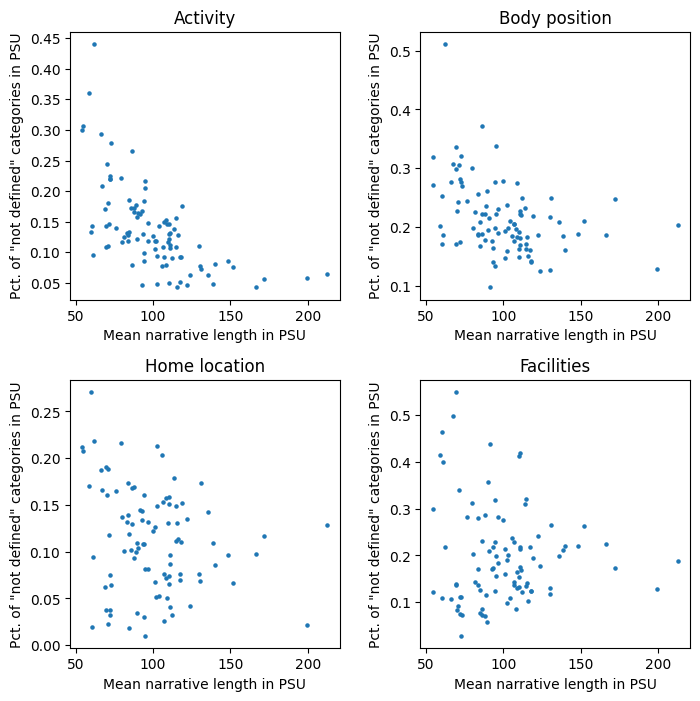

In [15]:
# Plot 'not defined' percetanges by PSU
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# Activity
axs[0, 0].scatter(df_psu['narrative_len'], df_psu['activity_nan'], s=5)
axs[0, 0].set_xlabel('Mean narrative length in PSU')
axs[0, 0].set_ylabel('Pct. of "not defined" categories in PSU')
axs[0, 0].set_title('Activity')
# Body position
axs[0, 1].scatter(df_psu['narrative_len'], df_psu['position_nan'], s=5)
axs[0, 1].set_xlabel('Mean narrative length in PSU')
axs[0, 1].set_ylabel('Pct. of "not defined" categories in PSU')
axs[0, 1].set_title('Body position')
# Home location
axs[1, 0].scatter(df_psu['narrative_len'], df_psu['homeloc_nan'], s=5)
axs[1, 0].set_xlabel('Mean narrative length in PSU')
axs[1, 0].set_ylabel('Pct. of "not defined" categories in PSU')
axs[1, 0].set_title('Home location')
# Facilities
axs[1, 1].scatter(df_psu['narrative_len'], df_psu['facility_nan'], s=5)
axs[1, 1].set_xlabel('Mean narrative length in PSU')
axs[1, 1].set_ylabel('Pct. of "not defined" categories in PSU')
axs[1, 1].set_title('Facilities')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()


Addressing incomplete data is always a challenge with no one-size-fits-all solution. One viable approach is imputing these categories using both textual and non-textual data. In our methodology, we considered 'not defined' categories as NAs and employed the miceforest algorithm for imputation utilizing non-textual variables such as 'product,' 'diagnosis,' 'body part', etc., as predictors for the missing categories. This method helped us partially mitigate biases stemming from disparities in the narrative descriptions.

In [16]:

# ------------------------ Imputation of the 'not defined' categories.

# ------ Combine in one dataset
df_full = df_full.merge(df_home[['cpsc_case_number', 'homeloc']], how='left')
df_full = df_full.merge(df_public[['cpsc_case_number', 'facility']], how='left')
df_full[['homeloc', 'facility']] = df_full[['homeloc', 'facility']].fillna('not applicable')

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# --- MICEFROST
df_full_mice = df_full[['age', 'female', 'race', 'hospitd', 'location',
                        'alcohol', 'drug',
                        'product_1', 'product_2', 'product_3',
                        'diagnosis', 'diagnosis_2',
                        'body_part', 'body_part_2',
                        'stratum', 'psu', 'year', 'month', 
                        'fall', 'activity', 'position', 'cause',
                        'homeloc', 'facility']]

# --- One-hot-encoding

# 1. product
df_full_mice['product_list'] = df_full_mice[['product_1', 'product_2', 'product_3']].apply(
    lambda row: list(row), 1)
df_full_mice['product_list'] = df_full_mice['product_list'].apply(
    lambda lst: list(filter(lambda x: x != '0 - None', lst)))
df_product = pd.DataFrame(mlb.fit_transform(df_full_mice['product_list']))
df_product.columns = mlb.classes_
df_product.columns = ['product_' + x for x in df_product.columns]
df_full_mice = df_full_mice.drop(columns={'product_1', 'product_2', 'product_3', 'product_list'})
df_full_mice = pd.concat([df_full_mice, df_product], 1)

# 2. diagnosis
df_full_mice['diagnosis_list'] = df_full_mice[['diagnosis', 'diagnosis_2']].apply(
    lambda row: list(row), 1)
df_full_mice['diagnosis_list'] = df_full_mice['diagnosis_list'].apply(
    lambda lst: list(filter(lambda x: type(x)==str, lst)))
df_diagnosis = pd.DataFrame(mlb.fit_transform(df_full_mice['diagnosis_list']))
df_diagnosis.columns = mlb.classes_
df_diagnosis.columns = ['diagnosis_' + x for x in df_diagnosis.columns]
df_full_mice = df_full_mice.drop(columns={'diagnosis', 'diagnosis_2', 'diagnosis_list'})
df_full_mice = pd.concat([df_full_mice, df_diagnosis], 1)

# 3. body_part
df_full_mice['body_part_list'] = df_full_mice[['body_part', 'body_part_2']].apply(
    lambda row: list(row), 1)
df_full_mice['body_part_list'] = df_full_mice['body_part_list'].apply(
    lambda lst: list(filter(lambda x: type(x)==str, lst)))
df_body_part = pd.DataFrame(mlb.fit_transform(df_full_mice['body_part_list']))
df_body_part.columns = mlb.classes_
df_body_part.columns = ['body_part_' + x for x in df_body_part.columns]
df_full_mice = df_full_mice.drop(columns={'body_part', 'body_part_2', 'body_part_list'})
df_full_mice = pd.concat([df_full_mice, df_body_part], 1)

# Fill NA
df_full_mice['hospitd'] = df_full_mice['hospitd'].fillna(0)

# Rename columns
df_full_mice = df_full_mice.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Split back to Full, Home, Public
df_home_mice = df_full_mice[df_full_mice['location'] == 'HOME'].drop(
    columns={'location', 'activity', 'position', 'facility'})
df_public_mice = df_full_mice[df_full_mice['location'] == 'PUBLIC'].drop(
    columns={'location', 'activity', 'position', 'homeloc'})
df_full_mice = df_full_mice.drop(columns={'facility', 'homeloc'})

# Replace NAs
df_full_mice['position'] = df_full_mice['position'].replace({'position is not defined':np.nan})
df_full_mice['activity'] = df_full_mice['activity'].replace({'activity is not defined':np.nan})
df_public_mice['facility'] = df_public_mice['facility'].replace({'location is not defined':np.nan})
df_home_mice['homeloc'] = df_home_mice['homeloc'].replace({'location is not defined':np.nan})

# To categorical variables
df_home_mice.iloc[:,1:] = df_home_mice.iloc[:,1:].astype('category')
df_public_mice.iloc[:,1:] = df_public_mice.iloc[:,1:].astype('category')
df_full_mice.iloc[:,1:] = df_full_mice.iloc[:,1:].astype('category')

# --------- Run MICE

def runMICE(df):
    
    start_time = time.time()
    
    # Create kernel. 
    kds = mf.ImputationKernel(
      df,
      save_all_iterations=True,
      random_state=RANDOM_SEED
    )
    
    # Run the MICE algorithm
    kds.mice(5)
    
    # Return the completed dataset.
    df_imputed = kds.complete_data()
    
    print("--- %s seconds ---" % round((time.time() - start_time), 2))
    
    return df_imputed

df_home_imputed = runMICE(df_home_mice)
df_public_imputed = runMICE(df_public_mice)
df_full_imputed = runMICE(df_full_mice)


# Add imputed variables back
df_home['homeloc_imp'] = df_home_imputed['homeloc'].astype(str).values
df_public['facility_imp'] = df_public_imputed['facility'].astype(str).values
df_full['position_imp'] = df_full_imputed['position'].astype(str).values
df_full['activity_imp'] = df_full_imputed['activity'].astype(str).values

# Remove variables from full
df_full = df_full.merge(df_home[['cpsc_case_number', 'homeloc_imp']], how='left')
df_full = df_full.merge(df_public[['cpsc_case_number', 'facility_imp']], how='left')
df_full[['homeloc_imp', 'facility_imp']] = df_full[['homeloc', 'facility']].fillna('not applicable')

# Combine homeloc with old location variable
def combineLocations(row):
    
    if row['location'] == 'HOME':
        location = 'HOME: ' + row['homeloc_imp']
        
    elif row['location'] == 'PUBLIC':
        location = 'PUBLIC: ' + row['facility_imp']
        
    else:
        location = row['location']
        
    return location

df_full['location_ext'] = list(df_full.apply(lambda row: combineLocations(row), 1))

# ------ SAVE
df_full.to_pickle(WD / 'intermediate_outputs/df_full_imp.obj')


/tmp/ipykernel_115159/4036148147.py:76: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_home_mice.iloc[:,1:] = df_home_mice.iloc[:,1:].astype('category')
/tmp/ipykernel_115159/4036148147.py:77: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_public_mice.iloc[:,1:] = df_public_mice.iloc[:,1:].astype('category')
/tmp/ipykernel_115159/4036148147.py:78: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.c

--- 89.6 seconds ---


/home/ubuntu/miniconda3/envs/art/lib/python3.10/site-packages/miceforest/ImputationKernel.py:371: UserWarning: [race,psu,product_1211FOOTBALLACTIVITYAPPARELOREQUIPMENT,product_1267SOCCERACTIVITYAPPARELOREQUIPMENT,product_1616JEWELRY,product_4078LADDERSOTHERORNOTSPECIFIED,product_474TABLEWAREANDACCESSORIES,product_478DRINKINGGLASSESCUPSANDMUGS,body_part_00OTHER,body_part_38PUBICREGION] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


--- 31.12 seconds ---


/home/ubuntu/miniconda3/envs/art/lib/python3.10/site-packages/miceforest/ImputationKernel.py:371: UserWarning: [race,location,psu,body_part_0INTERNAL,body_part_00OTHER] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


--- 213.6 seconds ---


The final database with six predicted variables contained 2,046,735 records of all accidents for all adult patients during 2013-2022 period, including 481,268 records of 65+ year-olds with fall-related accidents.

# 3. Analysis

In [7]:
# Load the dataset
df_full = pd.read_pickle(WD / 'intermediate_outputs/df_full_imp.obj')

# Additional Preprocessing
df_full['psu'] = df_full['psu'].apply(lambda x: 'psu_' + str(x))
df_full['fall'] = (df_full['fall'] == 'fall').astype(int)

# Recode locations to other
recode_home = {'HOME: doorways':'HOME: other home location',
               'HOME: outdoor location':'HOME: other home location'}
recode_public = {'PUBLIC: outdoor location':'PUBLIC: other type of facility',
                 'PUBLIC: housing':'PUBLIC: other type of facility',
                 'PUBLIC: religious facilities':'PUBLIC: other type of facility',
                 'PUBLIC: penitentiary':'PUBLIC: other type of facility'}
df_full['location_ext'] = df_full['location_ext'].replace(recode_home)
df_full['location_ext'] = df_full['location_ext'].replace(recode_public)

### Descriptive Table

# Select only 65+ and falls
df_falls_old = df_full[(df_full['fall'] == 1) & (df_full['age'] >= 65)]

# Define the bins and their labels
bins = [64, 74, 84, 120]
labels = ["65-74", "75-84", "85+"]

# Apply the pd.cut() function
df_falls_old['age_group_2'] = pd.cut(df_falls_old['age'],
                                     bins=bins,
                                     labels=labels, right=False, include_lowest=True)
df_falls_old['age_group_2'] = df_falls_old['age_group_2'].astype(str)


def createCrosstab(df, groupvar):

    # Location
    cross_location = pd.crosstab(df['location_ext'], df[groupvar], normalize='columns')
    # Activity
    cross_activity = pd.crosstab(df['activity_imp'], df[groupvar], normalize='columns')
    # Position
    cross_position = pd.crosstab(df['position_imp'], df[groupvar], normalize='columns')
    # Cause
    cross_cause = pd.crosstab(df['cause'], df[groupvar], normalize='columns')
    
    # Combine
    cross_comb = pd.concat([cross_cause, cross_position, cross_activity, cross_location])
    cross_comb = np.round(cross_comb*100, 1)
    cross_comb = cross_comb.reset_index()
    cross_comb = cross_comb.rename(columns={'index':'category'})

    # Add variable column
    cols = ['location_ext', 'activity_imp', 'position_imp', 'cause']
    dfs = [pd.DataFrame({
        'category': df[col].unique(),
        'variable': col
    }) for col in cols]
    df_category_variable = pd.concat(dfs)
    
    # Remove general locations
    remove_locations = ['UNK', 'STREET', 'SPORTS', 'OTHER', 'SCHOOL']
    df_category_variable = df_category_variable[df_category_variable.apply(
        lambda row: (row['category'] not in remove_locations) | (row['variable'] != 'location_ext'), 1)]
    cross_comb = cross_comb.merge(df_category_variable)
    
    # Order columns
    columns_order = ['medical', 'not medical',
     'standing', 'sitting', 'lying', 'other body position',
     'locomotion', 'body positioning', 'stationary', 'manual handling', 'sports activity', 'other activity',
     'HOME: home in general', 'HOME: bedroom', 'HOME: bathroom', 'HOME: stairs', 'HOME: kitchen',
     'HOME: living room', 'HOME: other home location',
     'PUBLIC: assisted living', 'PUBLIC: retail spaces', 'PUBLIC: healthcare facilities', 'PUBLIC: food & hospitality',
     'PUBLIC: entertainment & leisure', 'PUBLIC: transportation hubs', 'PUBLIC: other type of facility']
    cross_comb = cross_comb.set_index("category")
    cross_comb = cross_comb.loc[columns_order]
    cross_comb = cross_comb.reset_index()
    
    # Change names
    cross_comb['variable'] = cross_comb.apply(lambda row: 'Home location' if row['category'].startswith('HOME') else row['variable'], 1)
    cross_comb['variable'] = cross_comb.apply(lambda row: 'Facilities' if row['category'].startswith('PUBLIC') else row['variable'], 1)
    cross_comb['variable'] = cross_comb['variable'].replace(
        {'cause':'Cause', 'position_imp':'Body position', 'activity_imp':'Activity'})
    cross_comb['category'] = cross_comb['category'].apply(lambda x: x.replace('HOME: ', ''))
    cross_comb['category'] = cross_comb['category'].apply(lambda x: x.replace('PUBLIC: ', ''))
    cross_comb['category'] = cross_comb['category'].str.capitalize()
    
    return cross_comb

# Crosstab by sex
df_cross_sex = createCrosstab(df_falls_old, 'sex')

# Crosstab by age group
df_cross_age = createCrosstab(df_falls_old, 'age_group_2')

# Merge together
df_cross_comb = df_cross_sex.merge(df_cross_age)

# Rename and reshuffle columns
df_cross_comb = df_cross_comb.rename(columns={'category':'Category', 'variable':'Variable',
                              'FEMALE':'Female', 'MALE':'Male'})
df_cross_comb = df_cross_comb.loc[:,['Variable', 'Category', 'Female', 'Male', '65-74', '75-84', '85+']]

The table below describes the distribution of the generated categories by age and sex for the fall-related subsample. On average, over 90% of older individuals' fall-related ED visits arise from non-medical causes. The majority of falls in the elderly occur from a standing position, but this declines with age, while falls from sitting or lying positions increase. More falls happen during locomotion and body positioning, with slightly higher rates in females. Previous studies have shown that most falls in the elderly occur at home (e.g., Boye et al., 2014; Moreland, Kakara, Haddad, Shakya, & Bergen, 2020), but our variables also reveal variations in falls in specific home locations. For instance, older patients’ falls in kitchens and living rooms are more infrequent than falls in other home places. About 11% of falls happen in assisted living facilities, and this rate increases with age.

In [8]:
print(df_cross_comb)

         Variable                 Category  Female  Male  65-74  75-84   85+
0           Cause                  Medical     6.6   9.5    8.3    8.2   6.5
1           Cause              Not medical    93.4  90.5   91.7   91.8  93.5
2   Body position                 Standing    75.1  72.7   78.2   75.0  69.8
3   Body position                  Sitting    10.5  11.6    8.9   10.5  13.0
4   Body position                    Lying    13.8  14.2   11.1   13.6  16.9
5   Body position      Other body position     0.7   1.5    1.8    0.9   0.4
6        Activity               Locomotion    51.5  48.5   53.6   51.2  46.7
7        Activity         Body positioning    26.8  23.5   21.5   25.1  29.9
8        Activity               Stationary    12.5  14.7   11.0   13.1  15.6
9        Activity          Manual handling     4.2   6.2    6.0    5.0   4.0
10       Activity          Sports activity     1.1   2.1    2.4    1.5   0.6
11       Activity           Other activity     3.9   5.0    5.5    4.2   3.2

In [9]:
# Additional preprocessing
df_full['year_month'] = df_full['treatment_date'].dt.to_period('M').astype("datetime64[ns]")
df_full['Age group'] = pd.cut(df_full['age'], bins=[0, 64, 120], labels=['18-64', '65+'])

# Filter only fall-related cases
df_falls = df_full[df_full['fall'] == 1]

# Group by month and age group
fall_summary = df_falls.groupby(['year_month', 'Age group']).size().unstack().fillna(0).reset_index() # old_group
fall_summary = fall_summary.melt(id_vars='year_month', value_name='count')
monthly_totals = df_full.groupby(['year_month', 'Age group']).size().reset_index()
monthly_totals = monthly_totals.rename(columns={0:'total_count'})
fall_summary = fall_summary.merge(monthly_totals)
fall_summary['pct_fall'] = fall_summary['count'] / fall_summary['total_count']

Further, we explore seasonal and yearly trends in this data.

The figure below displays the monthly falls for younger and older age groups. The upper panel shows the absolute number of falls, while the bottom panel represents falls as a proportion to other incidents. From the absolute numbers, we observed fewer falls in older individuals during the winter and a peak in the summer. This might simply indicate that people are generally less active (and hence fall rarely) in colder months. Indeed, when viewed proportionally to other incidents, older individuals are more prone to encounter falls than other incidents during the winter. 

Additionally, when accounting for other incidents, the sharp increase in falls for older ages and a drop associated with COVID-19 became less pronounced. This implies that over time older individuals in the US might be just using emergency services more frequently (particularly, due to population ageing), rather than experiencing a significant fall-related decline in health.

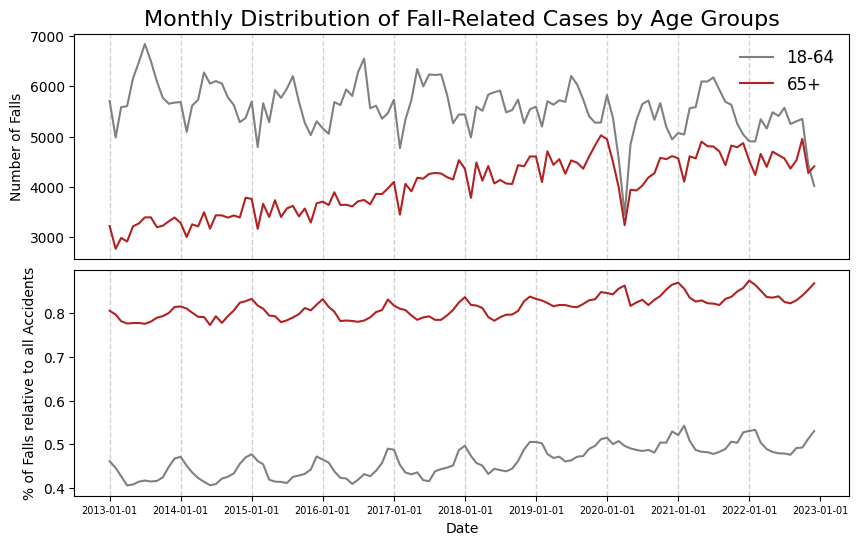

In [10]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(nrows=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.05)

# Plot 1
for year in fall_summary['year_month'].astype(str).str[:4].unique():
    axs[0].axvline(datetime.strptime(f'{year}-01-01', '%Y-%m-%d'), color='lightgray', linestyle='--', linewidth=1)
sns.lineplot(data=fall_summary, 
             x='year_month', y='count', hue='Age group', ax=axs[0],
             palette={'18-64': 'grey', '65+': 'firebrick'})

axs[0].set_title('Monthly Distribution of Fall-Related Cases by Age Groups', fontsize=16)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Falls')
axs[0].legend(frameon=False, fontsize=12)
axs[0].set_xticks([])

# Plot 2
for year in fall_summary['year_month'].astype(str).str[:4].unique():
    axs[1].axvline(datetime.strptime(f'{year}-01-01', '%Y-%m-%d'), color='lightgray', linestyle='--', linewidth=1)
sns.lineplot(data=fall_summary, 
             x='year_month', y='pct_fall', hue='Age group', ax=axs[1], legend=False,
             palette={'18-64': 'grey', '65+': 'firebrick'})
axs[1].set_title('', fontsize=16)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('% of Falls relative to all Accidents')

# Format x-axis as Y-M-D
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0, fontsize=7) # rotate x-axis labels

# plt.savefig(WD / "ts.svg")
plt.show()

In [7]:
from plotnine import *

### Regressions model

def predictProb(df, depvar, indvar):

    if indvar == 'baseline':
        model_formula = '{depvar} ~ age + female + race + drug + alcohol + year + month + psu'
        model_formula = model_formula.format(depvar=depvar)
        model = sm.GLM.from_formula(model_formula, data=df, family=sm.families.Binomial()).fit()
        
    else:
        model_formula = '{depvar} ~ age + female + race + drug + alcohol + year + month + psu + {indvar}'
        model_formula = model_formula.format(depvar=depvar, indvar=indvar)
        model = sm.GLM.from_formula(model_formula, data=df, family=sm.families.Binomial()).fit()

    # List with results
    list_results = {}

    # --- Baseline
    if indvar == 'baseline':
        
        df_predict = df.copy()
        pred = model.get_prediction(df_predict)
        pred_summary = pred.summary_frame()
        list_results["Baseline"] = {
            "estimate": pred_summary['mean'].mean(),
            "se": pred_summary['mean_se'].mean()
        }
            
        # print(indvar)

    # --- Cause
    if indvar == 'cause':
        
        list_causes = ['medical']
        for cause in list_causes:
            df_predict = df.copy()
            df_predict['cause'] = cause
            pred = model.get_prediction(df_predict)
            pred_summary = pred.summary_frame()
            list_results[f"Cause: {cause.capitalize()}"] = {
                "estimate": pred_summary['mean'].mean(),
                "se": pred_summary['mean_se'].mean()
            }
            
            # print(cause)

    # --- Position
    if indvar == 'position_imp':
        
        list_positions = list(filter(
            lambda x: x not in set(['other body position']), df['position_imp'].unique()))
        # list_positions = df['position_imp'].unique()
        for position in list_positions:
            df_predict = df.copy()
            df_predict['position_imp'] = position
            pred = model.get_prediction(df_predict)
            pred_summary = pred.summary_frame()
            list_results[f"Position: {position.capitalize()}"] = {
                "estimate": pred_summary['mean'].mean(),
                "se": pred_summary['mean_se'].mean()
            }
            
            # print(position)
    
    # Activities
    if indvar == 'activity_imp':
        list_activities = list(filter(
             lambda x: x not in set(['other activity']), df['activity_imp'].unique()))
        for activity in list_activities:
            df_predict = df.copy()
            df_predict['activity_imp'] = activity
            pred = model.get_prediction(df_predict)
            pred_summary = pred.summary_frame()
            list_results[f"Activity: {activity.capitalize()}"] = {
                "estimate": pred_summary['mean'].mean(),
                "se": pred_summary['mean_se'].mean()
            }
            
            # print(activity)
        
    # Location
    if indvar == 'location_ext':
        list_locations = list(filter(
            lambda x: x not in set(['UNK', 'STREET', 'SPORTS', 'OTHER', 'SCHOOL',
                                    'HOME: other home location', 'HOME: home in general',
                                    'PUBLIC: other type of facility']),
            df['location_ext'].unique()))
        for location in list_locations:
            df_predict = df.copy()
            df_predict['location_ext'] = location
            pred = model.get_prediction(df_predict)
            pred_summary = pred.summary_frame()
            list_results[f"Location: {location.capitalize()}"] = {
                "estimate": pred_summary['mean'].mean(),
                "se": pred_summary['mean_se'].mean()
            }
            
            # print(location)

    # Convert to dataframe
    df_results = pd.DataFrame(list_results).T
    df_results['upper'] = df_results['estimate'] + df_results['se'] * 1.98
    df_results['lower'] = df_results['estimate'] - df_results['se'] * 1.98
    df_results['label'] = df_results.index
    df_results['variable'] = indvar

    return df_results


def getEstimates(df, depvar):

    # --- 18-64
    list_vars = ['baseline', 'cause', 'position_imp', 'activity_imp', 'location_ext']
    df_est_young = []
    for varname in list_vars:
        df_temp = predictProb(df[(df['age'] < 65)], depvar, varname)
        df_est_young.append(df_temp)
        # print(varname)
    df_est_young = pd.concat(df_est_young)
    df_est_young['age_group'] = '18-64'
    
    # --- 65+
    list_vars = ['baseline', 'cause', 'position_imp', 'activity_imp', 'location_ext']
    df_est_old = []
    for varname in list_vars:
        df_temp = predictProb(df[(df['age'] >= 65)], depvar, varname)
        df_est_old.append(df_temp)
        # print(varname)
    df_est_old = pd.concat(df_est_old)
    df_est_old['age_group'] = '65+'
    
    # Combine
    df_est = pd.concat([df_est_young, df_est_old])
    
    return df_est

In [12]:
# --- Risk of falling
df_est_fall = getEstimates(df_full, 'fall')
df_est_fall.to_pickle(WD / 'intermediate_outputs/df_est_fall.obj')

# --- Risk of hospitalization after falling
df_falls = df_full[df_full['fall'] == 1]
df_est_hospitd = getEstimates(df_falls, 'hospitd')
df_est_hospitd.to_pickle(WD / 'intermediate_outputs/df_est_hospitd.obj')

In [13]:
def plotEstimates(df_est, title, x_title):

    # Rename columns
    df_est.index = df_est.index.str.replace('Location: ', '')
    df_est['label'] = df_est['label'].index.str.replace('Location: ', '')
    df_est.index = df_est.index.str.replace('Public: ', 'Facilities: ')
    df_est['label'] = df_est['label'].index.str.replace('Public: ', 'Facilities: ')

    # Reorder 'variable' levels based on the 65+ group
    order_df = (df_est[df_est['age_group'] == '65+']['estimate']).reset_index()
    order_df['variable'] = order_df['index'].apply(lambda x: x.split(':')[0])
    order_df = order_df.groupby('variable', group_keys=False).apply(lambda x: x.sort_values('estimate', ascending=True))
    df_est['label'] = df_est['label'].astype('category').cat.reorder_categories(
        order_df['index'], ordered=True)
    
    # Get baseline values
    baseline_18_64 = float(df_est[(df_est['label'] == 'Baseline') & (df_est['age_group'] == '18-64')]['estimate'])
    baseline_65 = float(df_est[(df_est['label'] == 'Baseline') & (df_est['age_group'] == '65+')]['estimate'])
    
    # Remove baseline from plot
    df_est = df_est[df_est['label'] != 'Baseline']

    # PLOT
    plot = (ggplot(df_est, aes(y='label', x='estimate', color='age_group'))
     + geom_vline(xintercept = baseline_18_64, linetype = "dashed", size = 0.4, color='grey')
     + geom_vline(xintercept = baseline_65, linetype = "dashed", size = 0.4, color='firebrick')
     + geom_line(aes(group='label'), size=0.3, color='grey', linetype="dashed")
     + geom_point(aes(color='age_group'), size=2)
     + scale_color_manual(values=['grey', 'firebrick']) # added line to change color of points
     + labs(color='Age group', y='')
     + theme_minimal()
     + theme(plot_title=element_text(size=14, face="bold", hjust=0.5),
             # legend_position='right',
             legend_position='right',
             legend_text=element_text(size=12),
             axis_text_y=element_text(face="bold"),
             axis_title_x=element_text(size=14),
             panel_grid_major_x=element_blank(),
             panel_grid_minor_x=element_blank(),
             panel_grid_major_y=element_blank(),
             panel_grid_minor_y=element_blank(),
             figure_size=(8, 6))
     + ggtitle(title)
     + xlab(x_title)
    )
    
    if x_title == 'Probability':
        plot = (plot + annotate('text', x=baseline_18_64+0.02, y = 10, size=7, label='Baseline 18-64', color='grey', angle=90)
                + annotate('text', x=baseline_65+0.02, y = 10, size=7, label='Baseline 65+', color='firebrick', angle=90))
    else:
        plot = (plot + annotate('text', x=baseline_18_64+0.01, y = 10, size=7, label='Baseline 18-64', color='grey', angle=90)
                    + annotate('text', x=baseline_65+0.01, y = 10, size=7, label='Baseline 65+', color='firebrick', angle=90))
    
    return plot
    # print(plot)
    

Using the entire database and fixed-effects logistic regressions, we estimated the effects of the obtained variables on the (1) probability of falling vs. encountering other incidents (the first plot) and (2) post-falling risk of hospitalization (the second plot). 

For each dependent variable, we used several fixed-effects logistic regression models. Each model included just one predictor variable along with control covariates (sex, age, race, drug/alcohol usage, year, month, hospital ID). We separated the analysis by predictors due to their intercorrelation. For instance, "stairs" as a home location often overlaps with the "locomotion" category in the activity variable.

Compared to the baseline, older people were especially prone to visit ED due to falling rather than other reasons when sitting or lying, walking on stairs, in assisted living, and when being stationary before the incident. Yet, these factors were not the strongest predictors of the post-fall hospitalization: the likelihood of hospitalization increased mostly due to medical reasons and movement activities (locomotion and body positioning). It should be noted that for older individuals, medical reasons did not seem to result in falls more frequently than in other accidents compared to the baseline; the opposite was true for younger people. 

Sports activities and manual tasks show reduced probability of both falls (vs. other incidents) and a post-fall hospitalization, especially for older people. This might indicate those participating in such activities are generally healthier or more cautious. Falls in bathrooms, kitchens, and bedrooms were more likely lead to hospitalization for older people than falls in other home locations and facilities, even more so than stair falls.

The lines between the point estimates in the graphs show how distant in terms of effects sizes older patients are from younger ones. For example, living rooms and bedrooms were more strongly associated with increased falls (vs. other incidents) for older than younger adults, whereas stairs or assisted living increased the probability of falls for both ages to a similar degree.


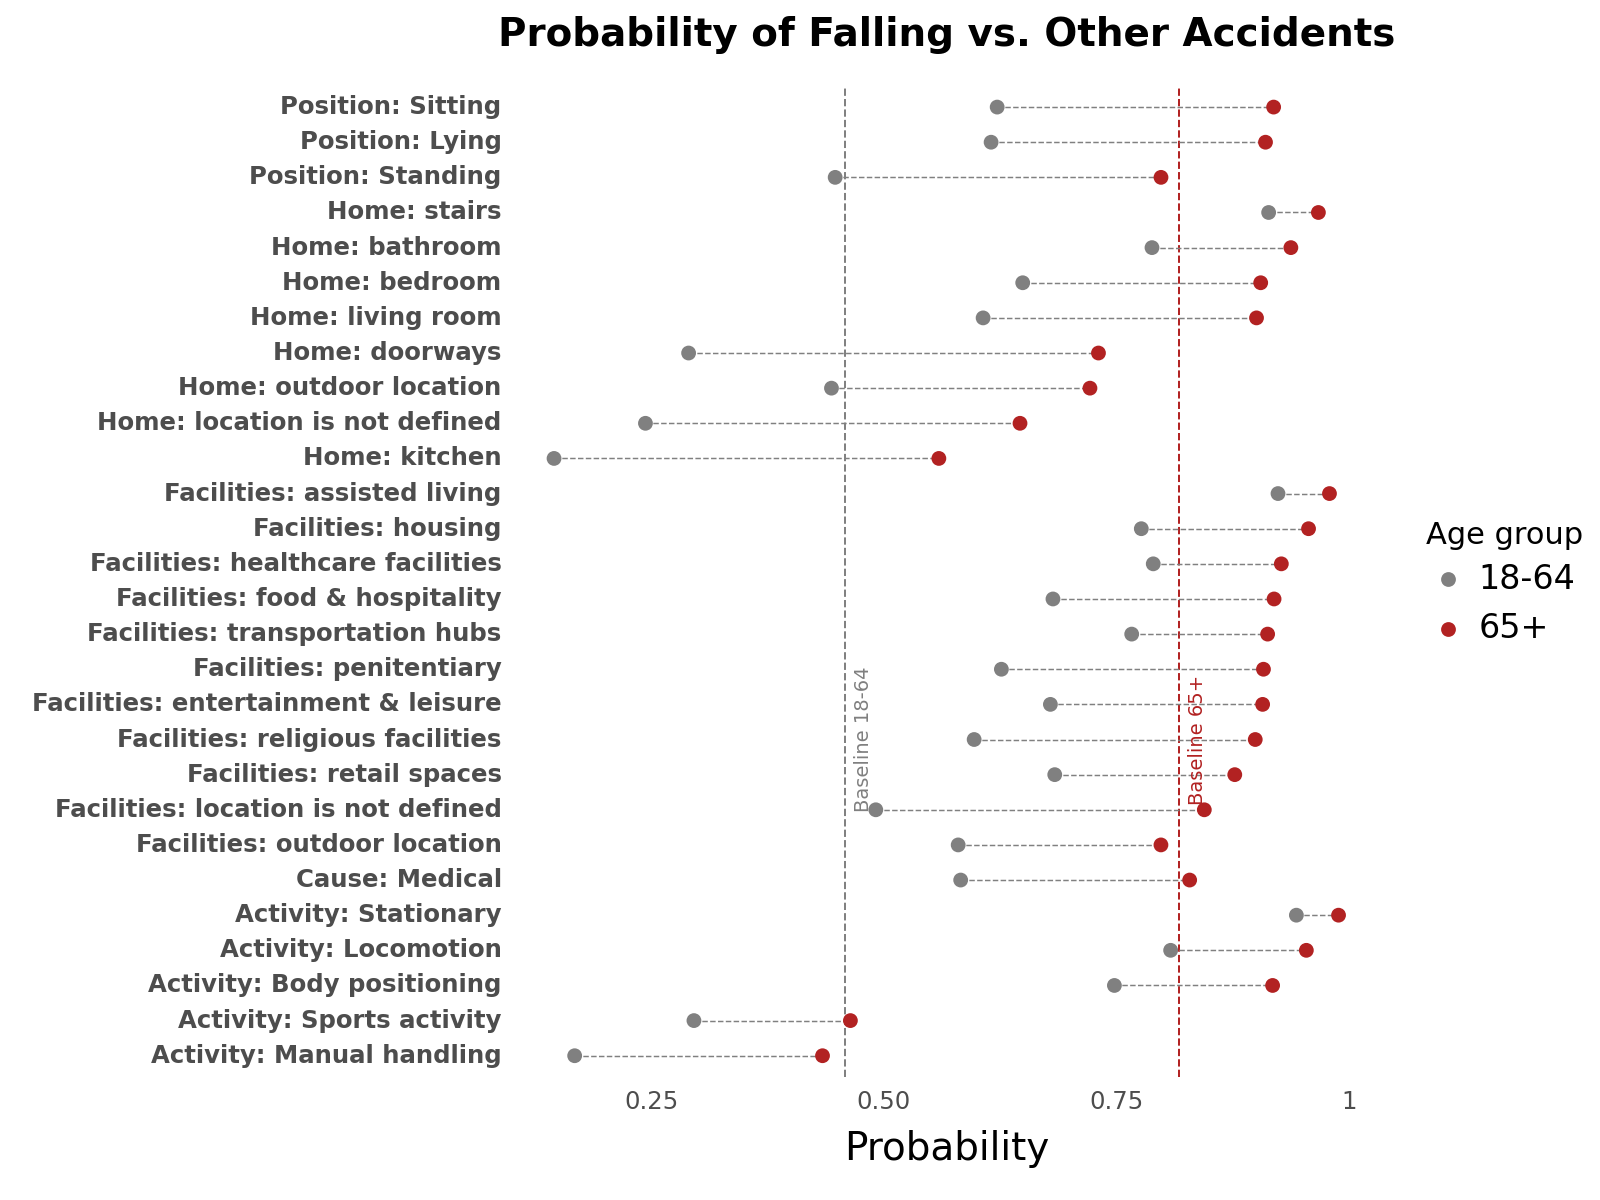

In [14]:
df_est_fall = pd.read_pickle(WD / 'intermediate_outputs/df_est_fall.obj')
plot = plotEstimates(df_est_fall, 'Probability of Falling vs. Other Accidents', 'Probability')
# plot.save(filename = WD / 'regression_fall.svg')
print(plot)

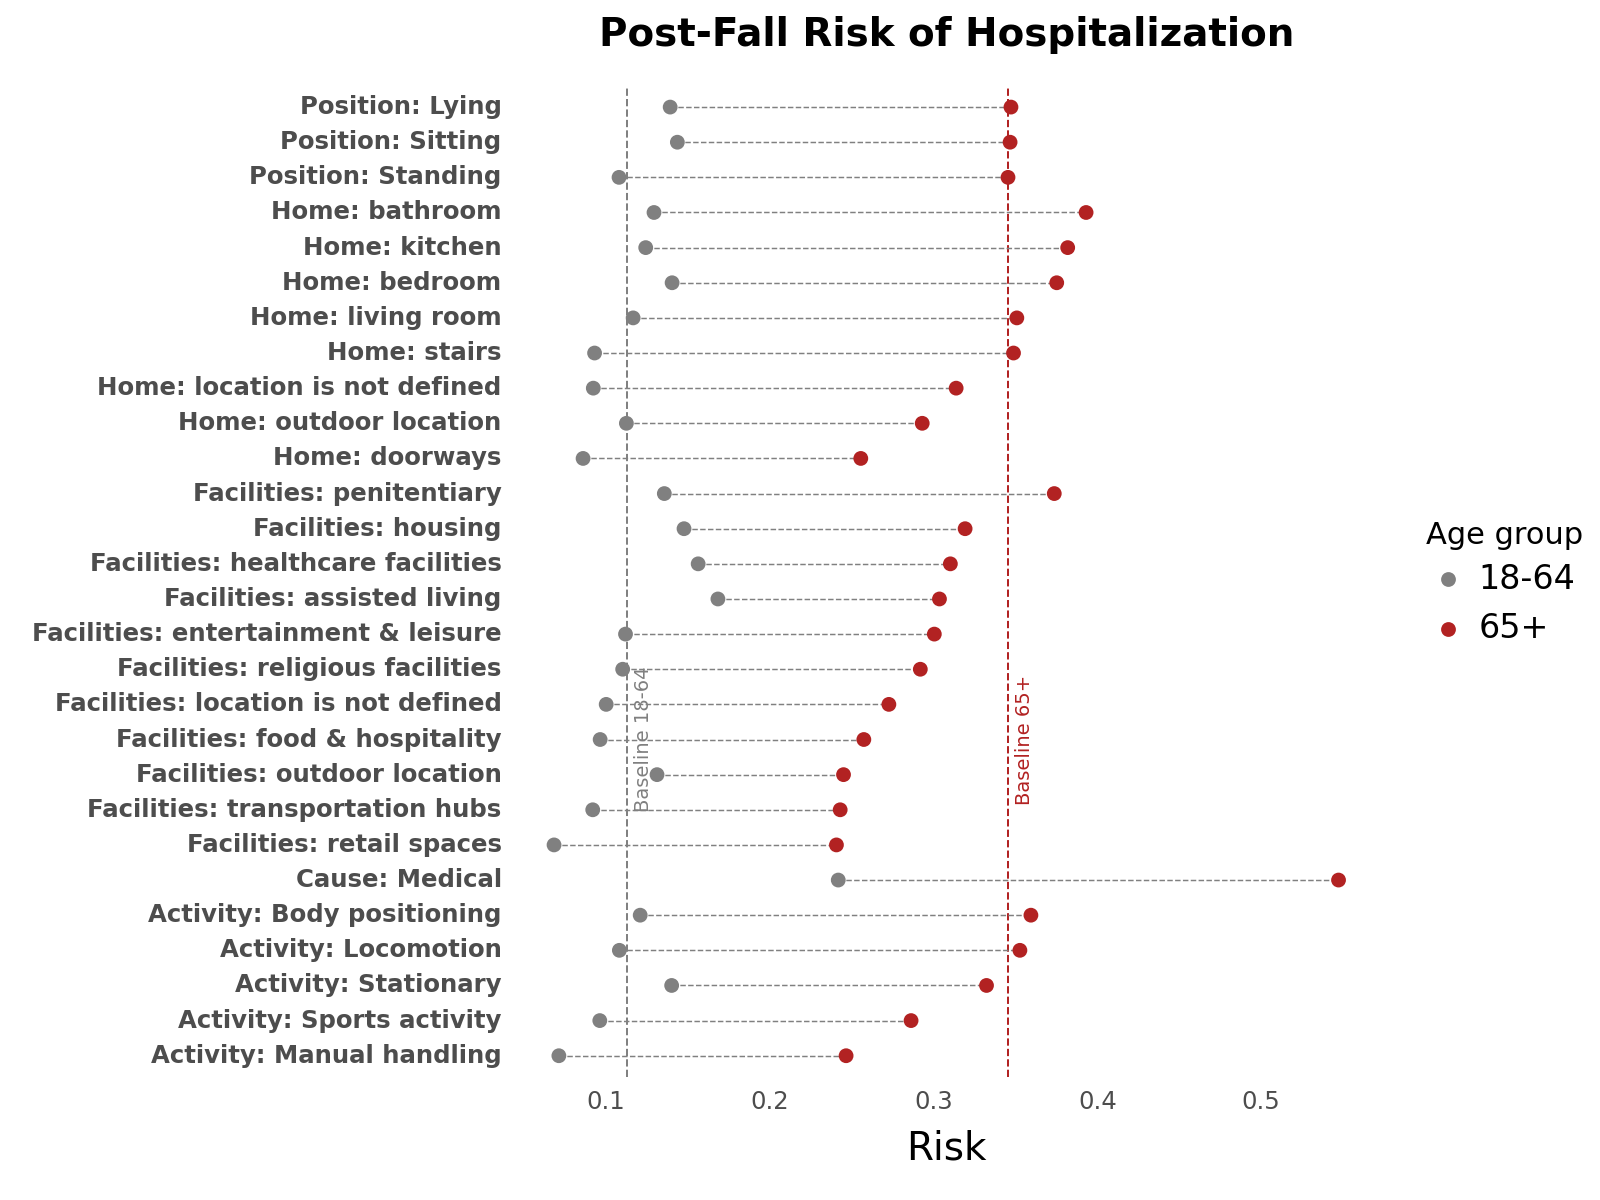


None


In [15]:
df_est_hospitd = pd.read_pickle(WD / 'intermediate_outputs/df_est_hospitd.obj')
plot = plotEstimates(df_est_hospitd, 'Post-Fall Risk of Hospitalization',  'Risk')
# plot.save(filename = WD / 'regression_hospitd.svg')
print(print(plot))

# 4. Discussion & Conclusion

This study combines the benefits of human-driven categorization with the automation potential of AI. We employed a downsampling strategy, integrating few-shot learning with ChatGPT and ML classification methods, to label extensive text samples and extract fall-related variables from the narrative data. The general approach is suitable for diverse research objectives and large datasets, and can be applied to other topics such as car accidents or opioid fatalities. The approach also enabled us to process the entire narratives data with all ED visits between 2013 and 2023, providing broader insights crucial for policymaking.

However, our approach has limitations. It requires proprietary access to the ChatGPT API and demands manually creating variables and categories. When refining this method, researchers must address multiple error sources: potential inaccuracies in ChatGPT labeling, classification model mispredictions, and biases (missing values) stemming from the narrative-specific attributes of hospitals, medical professionals, and patients (e.g., older people report less information, changes in the methodology). In this study, external validation was used to deal with the first and second biases, while missing data imputation was used to treat the third one.

We found that open-source models like Llama were not as effective as GPT-3.5 and GPT-4. Specifically, GPT-4 showed superior performance over GPT-3.5, especially when it came to labeling multi-categorical variables. Binary variables were generally more accurately labeled than the multi-categorical ones, and categories such as "Other" and "Not defined" were particularly challenging for our pipeline to be classified correctly. Drawing multiple answers from the GPT API as opposed to a single response did not enhance the accuracy. Furthermore, using advanced prompt engineering techniques, like chain-of-thoughts, had minimal impact on our results. As for the classification phase, we observed that intricate ML models did not offer a significant advantage, i.e., a simple SVM delivered the best results.

We found several substantive relationships regarding older adult falls. There was a variability in seasonal and yearly trends based on whether absolute or relative measures were used. Older individuals were more prone to ED visits from falls (vs. other accidents) when sitting, lying, being in assisted living, walking on stairs, or being stationary compared to the baseline. However, the risk of hospitalization after a fall increased due to medical issues and movement-related activities. In contrast, sports and manual tasks decreased the chances of falls and subsequent hospitalizations for the elderly. Falls in bathrooms, kitchens, and bedrooms posed a higher hospitalization risk for older individuals compared to other places. We also illustrated some age-based differences, providing a valuable comparative view.

Future work may include carrying out a sensitivity analysis, possibly by changing the sequence of examples in the prompt or by gauging the consistency of answers when making slight adjustments to the prompt. Additionally, there is potential in finetuning the transformer model for the classification stage instead of relying on embeddings paired with SVM. Testing and validation stages can also be expanded to encompass other types of accidents.




# References

1.	Boyé, Nicole D. A., Francesco U. S. Mattace-Raso, Nathalie Van Der Velde, Esther M. M. Van Lieshout, Oscar J. De Vries, Klaas A. Hartholt, Albert J. H. Kerver, Milko M. M. Bruijninckx, Tischa J. M. Van Der Cammen, Peter Patka, and Ed F. Van Beeck. 2014. ‘Circumstances Leading to Injurious Falls in Older Men and Women in the Netherlands’. Injury 45(8):1224–30. doi: 10.1016/j.injury.2014.03.021.

2.	Kakara, Ramakrishna S., Briana L. Moreland, Yara K. Haddad, Iju Shakya, and Gwen Bergen. 2021. ‘Seasonal Variation in Fall-Related Emergency Department Visits by Location of Fall – United States, 2015’. Journal of Safety Research 79:38–44. doi: 10.1016/j.jsr.2021.08.002.

3.	Moreland, Briana L., Ramakrishna Kakara, Yara K. Haddad, Iju Shakya, and Gwen Bergen. 2021. ‘A Descriptive Analysis of Location of Older Adult Falls That Resulted in Emergency Department Visits in the United States, 2015’. American Journal of Lifestyle Medicine 15(6):590–97. doi: 10.1177/1559827620942187.

4.	Omaki, Elise, Wendy Shields, Masoud Rouhizadeh, Pamela Delgado-Barroso, Ruth Stefanos, and Andrea Gielen. 2023. ‘Understanding the Circumstances of Paediatric Fall Injuries: A Machine Learning Analysis of NEISS Narratives’. Injury Prevention ip–2023–044858. doi: 10.1136/ip-2023-044858.

5.	Shakya, Iju, Gwen Bergen, Yara K. Haddad, Ramakrishna Kakara, and Briana L. Moreland. 2020. ‘Fall-Related Emergency Department Visits Involving Alcohol among Older Adults’. Journal of Safety Research 74:125–31. doi: 10.1016/j.jsr.2020.06.001.

